In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys
import seaborn as sns
sns.set_theme()

import numpy as np
import pandas as pd

import wandb
wandb.login()
api = wandb.Api()

sweeps = [
    api.sweep("chryu/pusht_dp/mny9gbjk"),
    api.sweep("chryu/pusht_bc/egk45aii"),
    api.sweep("dpfrommer-projects/pusht_estimator/wtlc1a37"),
]

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dpfrommer (dpfrommer-projects). Use `wandb login --relogin` to force relogin


In [2]:

data = []
for sweep in sweeps:
    for r in sweep.runs:
        config = r.config
        run = {
            "mean_reward": r.summary.get("mean_reward", None) or r.summary.get("reward_mean", None),
            "std_reward": (r.summary.get("std_reward",None) or r.summary.get("reward_std", None))/np.sqrt(16), # mean std
            "trajectories": config["train_trajectories"],
            "rel_action": True
        }
        if config["method"] == "estimator":
            run.update({
                "method": f"est/{config["env_type"]}",
                "rel_action": config["estimator"]["relative_actions"]
            })
        elif config["method"] == "diffusion_policy":
            run.update({"method": "diffusion_policy"})
        elif config["method"] == "bc":
            run.update({"method": "bc"})
        data.append(run)

data = pd.DataFrame(data)
data

,mean_reward,std_reward,trajectories,rel_action,method
0,0.871708,0.069642,174,True,diffusion_policy
1,0.699916,0.107802,130,True,diffusion_policy
2,0.590950,0.111180,80,True,diffusion_policy
3,0.415824,0.092545,30,True,diffusion_policy
4,0.524023,0.101539,174,True,bc
5,0.479532,0.095687,130,True,bc
6,0.384337,0.084472,80,True,bc
7,0.397718,0.081018,30,True,bc
8,0.426574,0.092188,174,False,est/positional
9,0.519522,0.092697,130,False,est/positional


In [3]:
def plot_err(x, y, yerr, **kwargs):
    plt.plot(x, y, **kwargs)
    fill_kwargs = {}
    if "color" in kwargs: fill_kwargs["color"] = kwargs["color"]
    # plt.fill_between(x, y-yerr, y+yerr, alpha=0.1, **fill_kwargs)

def color_br(color, scale_l=0.5):
    try:
        c = mc.cnames[color]
    except:
        c = color
    h, l, s = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

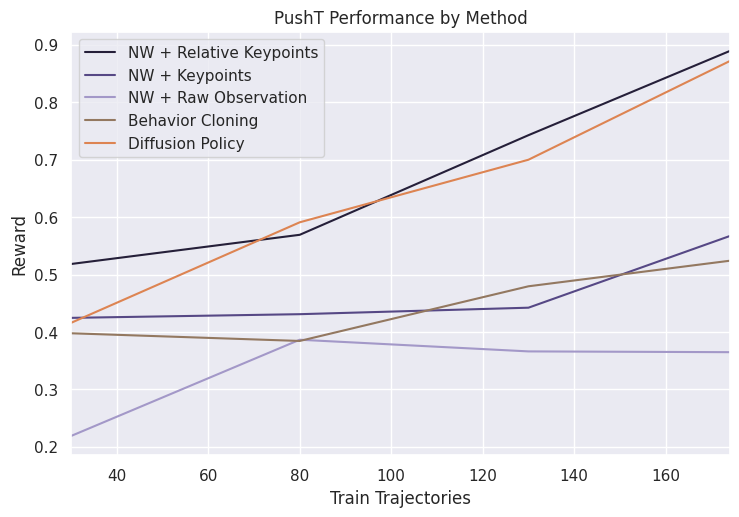

In [9]:
rel_action = data[data["rel_action"] == True]

palette = sns.color_palette()

EST_COLOR = palette[4]
BC_COLOR = palette[6]
DP_COLOR = palette[1]

styles = {
    "est/rel_keypoint": {"color": color_br(EST_COLOR, 0.3), "label": "NW + Relative Keypoints"},
    "est/keypoint": {"color": color_br(EST_COLOR, 0.7), "label": "NW + Keypoints", "linestyle": "-" },
    "est/positional": {"color": color_br(EST_COLOR, 1.2), "label": "NW + Raw Observation", "linestyle": "-"},
    "bc": {"color": BC_COLOR, "label": "Behavior Cloning"},
    "diffusion_policy": {"color": DP_COLOR, "label": "Diffusion Policy"}
}
series = {method: method_data for method, method_data in rel_action.groupby("method")}
for method in styles.keys():
    method_data = series[method]
    plot_err(method_data["trajectories"], 
        method_data["mean_reward"], 
        method_data["std_reward"],
        **styles.get(method, {})
    )
fig = plt.gcf()
fig.set_size_inches(8.5, 5.5)
plt.title("PushT Performance by Method")
plt.ylabel("Reward")
plt.xlabel("Train Trajectories")
plt.xlim(30, 174)
plt.legend()
plt.savefig("pusht_methods.svg")


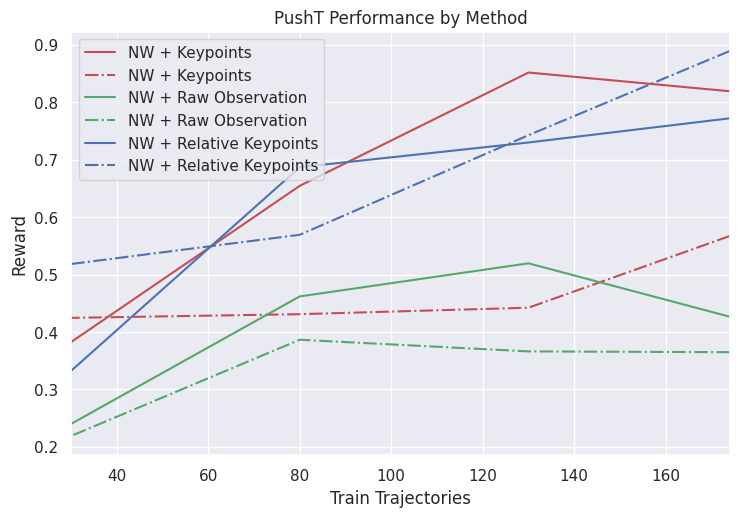

In [5]:
palette = sns.color_palette()

styles = {
    "est/rel_keypoint": {"color": palette[0], "label": "NW + Relative Keypoints"},
    "est/keypoint": {"color": palette[3], "label": "NW + Keypoints"},
    "est/positional": {"color": palette[2], "label": "NW + Raw Observation"},
}
for method, method_data in data.groupby("method"):
    if not method.startswith("est"): continue
    for rel_action, method_data in method_data.groupby("rel_action"):
        style = styles.get(method, {})
        plot_err(method_data["trajectories"], 
            method_data["mean_reward"], 
            method_data["std_reward"],
            linestyle="-." if rel_action else "-",
            **style
        )
fig = plt.gcf()
fig.set_size_inches(8.5, 5.5)
plt.title("PushT Performance by Method")
plt.ylabel("Reward")
plt.xlabel("Train Trajectories")
plt.xlim(30, 174)
plt.legend()
plt.savefig("pusht_methods.svg")
